<h1>ALA 470 Final Project</h1>
</br>
By Haley Johnson

In [1]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

<h2>Load Data</h2>

In [2]:
df = pd.read_csv("fake.csv")
df_2 = pd.read_csv("news_articles.csv")

In [87]:
with open('stopwords.txt') as s:
    stopwords = s.read()

In [88]:
stopwords = stopwords.split(" ")

<h2>Clean Up</h2>

In [3]:
# UNCOMMENT IF YOU WANT TO USE BOTH FILES
# df_1['title'] = df_1['title'].str.lower()
# df_1['author'] = df_1['author'].str.lower()

# df_1 = df_1.drop(columns = {'language', 'site_url', 'main_img_url', 'type', 'published', 'text'}, axis = 1)

# df_2['title'] = df_2['title'].str.lower()
# df_2['author'] = df_2['author'].str.lower()

# df = df_1.merge(df_2, on = ['title', 'author'])

<h2>NLTK</h2>

In [4]:
df.columns

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'],
      dtype='object')

<h3>Tokenize</h3>

In [5]:
df['text'] = df['text'].astype(str)

In [6]:
df['text_normalized'] = df['text'].str.lower()

In [7]:
df['tokens'] = df['text_normalized'].apply(lambda t: [word for sent in nltk.sent_tokenize(t) for word in nltk.word_tokenize(sent)])

In [89]:
df['non_stopwords'] = df['tokens'].apply(lambda x: [w for w in x if w not in stopwords])
df['non_stopwords_count'] = df['non_stopwords'].apply(len)

<h3>Top Tokens by Type</h3>

In [90]:
types = list(df['type'].unique())

In [91]:
top_tokens = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded_tokens = matches.explode('non_stopwords')
    exploded_tokens = exploded_tokens[pd.isnull(exploded_tokens['non_stopwords']) == False]
    top_tokens.append(exploded_tokens['non_stopwords'].value_counts())

<h3>Filter Out Puncutation Tokens</h3>

In [92]:
punctuation = ["'", "'", '"', '"', ".", "?", ",", "!", "-", ",", ".", '”', '“', ";", ":", "(", ")", "’",
               '–', "&", '``', "''", "'s", "...", "http", "www", "https"]

In [93]:
for i in range(len(top_tokens)):
    current = top_tokens[i].reset_index().rename(columns = {'index': 'token', 'non_stopwords': 'count'} )
    current = current[current['token'].apply(lambda s: s not in punctuation) == True]
    top_tokens[i] = current

In [84]:
wub = top_tokens[1].sort_values(by = 'count', ascending = False)[:10]

[Text(0.5, 1.0, 'conspiracy')]

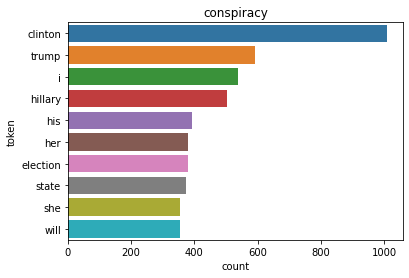

In [85]:
sns.barplot(x = wub['count'], y = wub['token']).set(title = types[1])

<h2>Visualize</h2>

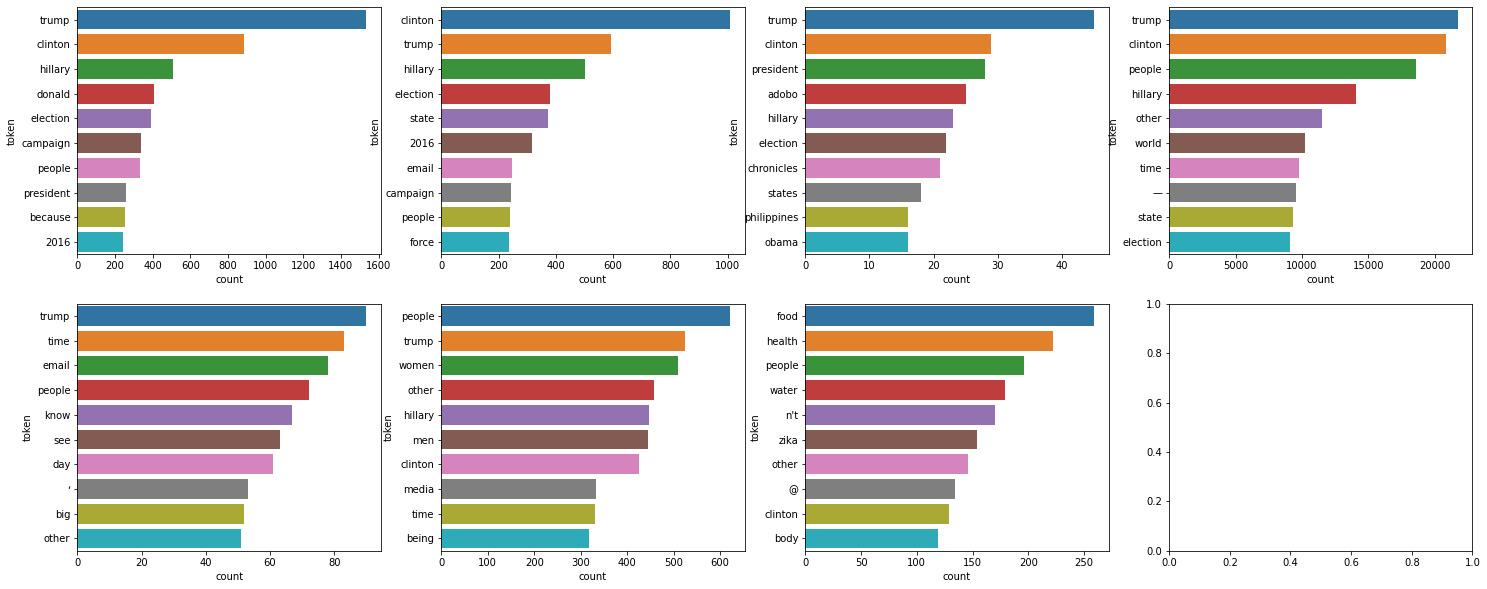

In [94]:
fig, axes = plt.subplots(2, 4, snare )
fig.set_size_inches(25, 10)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    top = top_tokens[i].sort_values(by = 'count', ascending = False)[:10]
    grid = sns.barplot(x = top['count'], y = top['token'], ax = ax)
    grid.set(title = )
    

<h3>Named Entity Recognition</h3>

In [ ]:
def get_people(s):
    people = []
    tokens = nltk.word_tokenize(s)
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)

    for entity in entities.subtrees():
        if entity.label() == "PERSON":
            name = []
            for leaf in entity.leaves():
                name.append(leaf[0])
            people.append(" ".join(name))
    return people

In [ ]:
df['Persons'] = df['text_normalized'].apply(get_people)

<h2>Visualize</h2>

In [ ]:
top = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('Persons')
    exploded = exploded[pd.isnull(exploded['Persons']) == False]
    top.append(exploded['Persons'].value_counts())

In [ ]:
fake = top[2]
top = top[:2] + top[3:]

In [ ]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    grid = sns.barplot(x = top[i].values, y = top[i].index, ax = ax)
    grid.set(ylabel = t)
    

In [ ]:
top[2]